# Optic Flow
The purpose of this repository is to demonstrate the concept of optical flow by implementing the 
Lucas Kanade algorithm, without use of any Image processing libraries.

## Lucas Kanade optical flow
A function which takes an image and returns the optical flow by using the LK algorithm.

In order to compute the optical flow, we first compute the gradients Ix and Iy and then over a window centered around each pixel we calculate:

$\begin{bmatrix}\sum{I_x I_x} & \sum{I_x I_y} \\
\sum{I_x I_y} & \sum{I_y I_y} \\ 
 \end{bmatrix}
\begin{bmatrix}u \\ v 
\end{bmatrix}
=\begin{bmatrix}\sum{I_x I_t} \\ \sum{I_y I_y} 
\end{bmatrix}$

while keep the below:

- $ \lambda_1 \geq \lambda_2 >1$ 
- $ \frac{\lambda_1}{\lambda_2} < 100$

For some points we not be able to get a good optical 
ow, meaning they won't pass the $ \lambda $ constraints.
That is why we return only the points that are good, since only they will have a matching $ \Delta X $;$ \Delta y $.

Notice:
LK algorithm is used for sub-pixel movements!
The best way to check your self is to take an image, apply a transformation (i.e. translation) and test.
Use the method displayOpticalFlow to look at the results, you can also check the mean of the $ \Delta X $;$ \Delta Y $ to see that it matches the initial transformation. Even if you had a simple translation, not all points will give the same optical flow, there will be some outliers.


In [3]:
def calculateLK(im1: np.ndarray, im2: np.ndarray, pnts: np.ndarray, win_size=5) -> (np.ndarray, np.ndarray):
    """
    Calculates the optical flow using Lukas-Kande algorithm
    :param im1: First Image
    :param im2: Second Image
    :param pnts: Points to calculate the optical flow
    :return: List of [x,y,[uv],mag], the location of the pixel in the first image,
            and the movement (uv) to its matching pixel, and the image magnification
    """
    Ix = cv2.Sobel(im2, cv2.CV_64F, 1, 0, ksize=3, scale=1 / 8)
    Iy = cv2.Sobel(im2, cv2.CV_64F, 0, 1, ksize=3, scale=1 / 8)
    It = (im2 - im1)

    window_size = win_size
    w_2 = window_size // 2
    h, w = im1.shape[:2]

    uv_lst = []
    pts = []
    pnts = pnts[pnts[:, 0] > w_2, :]
    pnts = pnts[pnts[:, 0] < h - w_2, :]
    pnts = pnts[pnts[:, 1] > w_2, :]
    pnts = pnts[pnts[:, 1] < w - w_2, :]
    for id_y, id_x in pnts:
        c_ix = Ix[id_y - w_2:id_y + w_2 + 1, id_x - w_2:id_x + w_2 + 1].ravel()
        c_iy = Iy[id_y - w_2:id_y + w_2 + 1, id_x - w_2:id_x + w_2 + 1].ravel()
        c_it = It[id_y - w_2:id_y + w_2 + 1, id_x - w_2:id_x + w_2 + 1].ravel()

        A = np.array([c_ix, c_iy])
        # Invertible check
        ATA = A @ A.T
        eig1, eig2 = np.linalg.eigvals(ATA)
        # Small eig. values check
        if eig1 < 10 or eig1 / eig2 > 2:
            continue

        b = -c_it.T
        ATb = A @ (b)
        uv = np.linalg.inv(ATA) @ (ATb)

        uv_lst.append(uv)
        pts.append((id_x, id_y))

    return np.array(pts), np.array(uv_lst)


def opticalFlow(im1: np.ndarray, im2: np.ndarray, step_size=10, win_size=5) -> (np.ndarray, np.ndarray):
    """
    Given two images, returns the Translation from im1 to im2
    :param im1: Image 1
    :param im2: Image 2
    :param step_size: The image sample size:
    :param win_size: The optical flow window size (odd number)
    :return: Original points [[y,x]...], [[dU,dV]...] for each points
    """
    h, w = im1.shape[:2]
    YX = np.mgrid[step_size:h:step_size, step_size:w:step_size]
    pts = YX.reshape((2, -1)).T

    pts, uv = calculateLK(im1, im2, pts, win_size)

    return pts, uv


def displayOpticalFlow(img: np.ndarray, pts: np.ndarray, uvs: np.ndarray):
    plt.imshow(img, cmap='gray')
    plt.quiver(pts[:, 0], pts[:, 1], uvs[:, 0], uvs[:, 1], color='r')

    plt.show()

In [14]:
def lkDemo(img_path):
    img_1 = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2GRAY)
    img_1 = cv2.resize(img_1, (0, 0), fx=.5, fy=0.5)
    t = np.array([[1, 0, -.2],
                  [0, 1, -.1],
                  [0, 0, 1]], dtype=float)
    img_2 = cv2.warpPerspective(img_1, t, img_1.shape[::-1])

    pts, uv = opticalFlow(img_1.astype(float), img_2.astype(float), step_size=20, win_size=5)
    displayOpticalFlow(img_2, pts, uv)

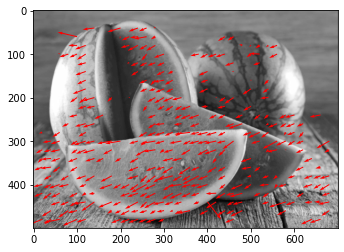

In [15]:
img_path = 'Israeli_watermelon.jpg'
lkDemo(img_path)